# Motif K-mer Analysis

In [3]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = ".jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import sklearn
from sklearn import preprocessing
import multiprocessing
import threading
from collections import Counter
import time
from sklearn import decomposition
from numba import jit
### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/signals_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## calculate differentially expressed genes

In [91]:
tag_dirs = sorted(os.listdir('./tag_directories_rna/'))
treated_dirs = ' '.join(['./tag_directories_rna/' + x for x in tag_dirs if not '_Veh-1h_' in x])
veh_dirs = ' '.join(['./tag_directories_rna/' +x for x in tag_dirs if  '_Veh-1h_' in x])

In [92]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -noadj -d $veh_dirs $treated_dirs > raw.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IL4-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IL4-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_R848-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_R848-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_Tgfb-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Tgfb-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09_20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_no

In [93]:
with open('./raw.tsv') as f:
    data = f.readline()

In [95]:
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[8:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./raw.tsv $condition_string > edgeR_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Veh-1h vs. IFNg-1h:
		Total Genes: 24453
		Total Up-regulated in IFNg-1h vs. Veh-1h: 63 (0.258%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IFNg-1h vs. Veh-1h: 142 (0.581%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. IL4-1h:
		Total Genes: 24453
		Total Up-regulated in IL4-1h vs. Veh-1h: 28 (0.115%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IL4-1h vs. Veh-1h: 39 (0.159%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. KLA-1h:
		Total Genes: 24453
		Total Up-regulated in KLA-1h vs. Veh-1h: 617 (2.523%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh-1h: 324 (1.325%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. R848-1h:
		Total Genes: 24453
		Total Up-regulated in R848-1h vs. Veh-1h: 5 (0.020%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in R848-1h vs. Veh-1h: 38 (0.

In [128]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
diff_expression_frame.columns = columns

## Read in Peak and Sequence Data

In [ ]:
! annotatePeaks.pl merged_atac_peaks_filtered_resized.tsv mm10 > ./atac_annotated_peaks.tsv

In [121]:
summary_frame = pd.read_csv('group_atac_summary.tsv', sep='\t')
annotation_frame = pd.read_csv('atac_annotated_peaks.tsv', sep='\t')

In [122]:
columns = annotation_frame.columns.values
columns[0] = 'PeakID'
annotation_frame.columns = columns
annotation_frame.index = annotation_frame['PeakID'].values

In [114]:
### read in sequences as dictionary {peakID: sequence}
with open('./peak_sequences/C57BL6J.fa') as f:
    data = f.readlines()

target_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        target_sequence_dict[sequenceName] = line.strip().upper()  

## read in background sequences
with open('./peak_sequences_background/C57BL6J.fa') as f:
    data = f.readlines()
background_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        background_sequence_dict[sequenceName] = line.strip().upper()[:200]
intersecting_ids = set(target_sequence_dict.keys()).intersection(set(background_sequence_dict.keys()))
for iid in intersecting_ids:
    del background_sequence_dict[iid]

# Ensemble Model using k-mer pairs

In [138]:
def calculate_kmer_interaction_matrix(id_sequence_dict, 
                                      k, 
                                      interaction_distances,
                                      verbose=False,
                                      create_pickle = False,
                                      pickle_prefix = None):
    '''
    Reads in a dictionary with id_sequence_dict and calculates a
    numSequences X interaction_distance X interaction_matrix
    '''
    ids = sorted(id_sequence_dict.keys())
    sequences = [id_sequence_dict[x] for x in ids]
#     print(interaction_distances)
    # initialize kmer indices
    kmer_pair_index_dict = {}
    counter = 0
    kmers = [''.join(x) for x in itertools.product(['A', 'C', 'G', 'T'], repeat=k)]
    kmer_pairs = []
    for i in range(len(kmers)):
        for j in range(len(kmers)):
            kmer_string = '-'.join([kmers[i], kmers[j]])
            kmer_pair_index_dict[kmer_string] = counter
            kmer_pairs.append(kmer_string)
            counter += 1
    # loop through different interaction distances
    interactionMatrixList_dict = {} # {interactionDistance, list of interaction matrices}
    lock = threading.Lock()
    thread_list = []
    for interaction_distance in interaction_distances:
        try:
            current_thread = threading.Thread(target = count_interactions,
                                              args = (sequences,
                                                      kmer_pair_index_dict,
                                                      interaction_distance,
                                                      verbose,
                                                      lock,
                                                      interactionMatrixList_dict)
                                             )
            thread_list.append(current_thread)
            current_thread.start()
        finally:
            if lock.locked_lock():
                lock.release()
    for current_thread in thread_list:
        current_thread.join()
    interactionMatrix_frame_dict = {}
    for distance in interactionMatrixList_dict.keys():
        frame = pd.DataFrame(interactionMatrixList_dict[distance], index = ids, columns=kmer_pairs)
        interactionMatrix_frame_dict[distance] = frame
    if create_pickle:
        if pickle_prefix == None:
            pickle_prefix = './'
        print('writing pickle file')
        pickle.dump(interactionMatrix_frame_dict, open(pickle_prefix + 'interactionMatrix_frame_dict.pickle', 'wb'))
    return interactionMatrix_frame_dict, kmer_pair_index_dict
    

In [139]:
def count_interactions(sequences,
                       kmer_pair_index_dict,
                       interaction_distance,
                       verbose,
                       thread_lock,
                       interactionMatrixList_dict
                       ):
    '''
    create a list of matrices of k-mer pairs
    '''
    # extract length of k-mers
    k = len(list(kmer_pair_index_dict.keys())[0].split('-')[0])
    
    # create list to hold results
    interactionMatrix_list = []
    for seq in sequences:
        # initialize matrix for sequence
        num_kmers = len(kmer_pair_index_dict)
        interaction_matrix = np.zeros(num_kmers, dtype=np.int16)
        
       
        scan_start = 0
        # leave room for last interacting kmer
        seq_length = len(seq)
        scan_end = seq_length - (2*k + interaction_distance) + 1
                
        for i in range(scan_start, scan_end):
            start_1 = i
            end_1 = start_1 + k
            
            start_2 = end_1 + interaction_distance
            end_2 = start_2 + k
            
            # calculate kmer
            kmer_1 = seq[start_1: end_1]
            kmer_2 = seq[start_2: end_2]
            
            # get kmer indices
            if not 'N' in kmer_1 and not 'N' in kmer_2:
                index = kmer_pair_index_dict[kmer_1 + '-' + kmer_2]
                # update matrix
                interaction_matrix[index] +=1
#             print(start_1, end_1, start_2, end_2, kmer_1, kmer_2)
        interactionMatrix_list.append(interaction_matrix)
        
    while thread_lock.locked_lock():
        time.sleep(1)
    thread_lock.acquire()
    interactionMatrixList_dict[interaction_distance] = np.array(interactionMatrix_list)



## Generate Features

In [ ]:
start = time.time()
if not os.path.isdir('./kmer_pair_matrices/'):
    os.mkdir('./kmer_pair_matrices/')
current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

interactionMatrix_frame_dict, k_mer_index_dict = calculate_kmer_interaction_matrix(target_sequence_dict, 
                                      3, 
                                      range(100),
                                      verbose=False,
                                      create_pickle = True,
                                      pickle_prefix = './kmer_pair_matrices/target_')
end = time.time()
print(end-start)
interactionMatrix_background_frame_dict, k_mer_index_dict = calculate_kmer_interaction_matrix(current_background_sequence_dict, 
                                      3, 
                                      range(100),
                                      verbose=False,
                                      create_pickle = True,
                                      pickle_prefix = './kmer_pair_matrices/background_')
end = time.time()
print(end-start)

In [ ]:
interactionMatrix_frame_dict = pd.read_pickle('./kmer_pair_matrices/target_interactionMatrix_frame_dict.pickle')
interactionMatrix_background_frame_dict = pd.read_pickle('./kmer_pair_matrices/background_interactionMatrix_frame_dict.pickle')

## Train Classifier

In [23]:
# split data into training and test data
def get_split(labels, test_size):
    '''
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    all_ids = true_ids + false_ids
    all_labels = labels[labels.index.isin(all_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(all_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(all_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [all_ids[i] for i in training_indices]
    test_ids = [all_ids[i] for i in test_indices]
    
    training_labels = all_labels[all_labels.index.isin(training_ids)]
    test_labels = all_labels[all_labels.index.isin(test_ids)]
    
    return training_labels, test_labels
    

In [ ]:
promoter_peakIDs= annotation_frame[annotation_frame['Annotation'].str.contains('promoter').fillna(False)].index.values
# kla_responsive_peakIDs = []
# for gene in up_genes:
#     current_frame = annotation_frame[(annotation_frame['Annotation'].str.contains('promoter')) &
#                  (annotation_frame['Gene Name'].str.upper() == gene)]
#     if current_frame.shape[0] > 0:
#         min_peakID = current_frame[
#             current_frame['Distance to TSS'] == current_frame['Distance to TSS'].min(axis=1)].index.values[0]
#         kla_responsive_peakIDs.append(min_peakID)

# features = normed_motif_frame[normed_motif_frame.index.isin(promoter_peakIDs)]
# labels = peak_frame[peak_frame.index.isin(promoter_peakIDs)]['ID'].isin(kla_responsive_peakIDs)

In [35]:
test_size = 0.5
numIterations = 1

In [ ]:
factor_list = []
treatment_list = []
auc_list = []
auc_type = []


strain = 'c57bl6'
interaction_distances = range(100)
interaction_weights_dict = {}
combined_weights_dict = {}
for treatment in ['veh', 'kla']:
    for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'pu1', 'cebpa']:
        print(factor, treatment)
        start = time.time()
        target_indices = summary_frame[summary_frame[strain + '_' + factor + '_' + treatment] > 0.0].index.values
        background_indices = np.array(list(current_background_sequence_dict.keys()))    # select subset of background indices to use

        
        training_classifier_scores = []
        testing_classifier_scores = []
        labels = pd.Series([True] * len(target_indices) + [False] * len(background_indices),
                                   index = np.concatenate([target_indices, background_indices],axis=0))
        interaction_weights_dict[factor+ '_'+treatment] = {}
        for i in range(numIterations):
        # split data
            training_labels, test_labels = get_split(labels, test_size = test_size)

            for interaction_distance in interaction_distances:
                # merge target and background features together 
                target_features = interactionMatrix_frame_dict[interaction_distance].ix[target_indices,:]
                background_features = interactionMatrix_background_frame_dict[interaction_distance].ix[background_indices,:]

                features = pd.concat([target_features, background_features])
                # standardize features
    #             scaler = preprocessing.StandardScaler()
    #             standardized_features = pd.DataFrame(scaler.fit_transform(features))
    #             standardized_features.columns = features.columns.values
    #             standardized_features.index = features.index.values

    #             training_features = standardized_features.ix[training_labels.index.values]
    #             test_features = standardized_features.ix[test_labels.index.values]
                training_features = features.ix[training_labels.index.values]
                test_features = features.ix[test_labels.index.values]

                # Train classifier for current distance
                current_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                current_classifier.fit(training_features, training_labels)

                # retrieve model coefficients
                current_coefficients = current_classifier.coef_.flatten()
                if not interaction_distance in interaction_weights_dict[factor+'_'+treatment]:
                    interaction_weights_dict[factor+'_'+treatment][interaction_distance] = []
                interaction_weights_dict[factor+'_'+treatment][interaction_distance].append(current_coefficients)
                
                # generate features for ensemble classifier
                current_training_scores = current_classifier.decision_function(training_features)
                current_testing_scores = current_classifier.decision_function(test_features)
                training_classifier_scores.append(current_training_scores)
                testing_classifier_scores.append(current_testing_scores)
                
                # score current_classifier
                current_probas = current_classifier.predict_proba(test_features)
                current_roc = sklearn.metrics.roc_auc_score(test_labels, current_probas[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, current_probas[:, 1], average = None)
                print(interaction_distance, current_roc, current_precision)

                factor_list.append(factor)
                treatment_list.append(treatment)
                auc_list.append(current_roc)
                auc_type.append(str(interaction_distance))

            # train combined classifier
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            training_combined_features = pd.DataFrame(training_classifier_scores).T
            testing_combined_features = pd.DataFrame(testing_classifier_scores).T
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve combined classifier coefficients
            combined_coefficients = combined_classifier.coef_.flatten()
            if not factor+'_'+treatment in combined_weights_dict:
                combined_weights_dict[factor+'_'+treatment] = []
            combined_weights_dict[factor+'_'+treatment].append(combined_coefficients)
            
            # score combined classifier
            combined_probas = combined_classifier.predict_proba(testing_combined_features)
            combined_roc = sklearn.metrics.roc_auc_score(test_labels, combined_probas[:, 1], average = None)
            combined_precision = sklearn.metrics.average_precision_score(test_labels, combined_probas[:, 1], average = None)
        end = time.time()
        
        print(factor, treatment, combined_roc, combined_precision, end-start)
        factor_list.append(factor)
        treatment_list.append(treatment)
        auc_list.append(combined_roc)
        auc_type.append('combined')

In [49]:
pickle.dump(interaction_weights_dict, open('./interaction_weights_dict.pickle', 'wb'))

pickle.dump(combined_weights_dict, open('./combined_weights_dict.pickle', 'wb'))

In [4]:
interaction_weights_dict = pickle.load(open('./interaction_weights_dict.pickle', 'rb'))

combined_weights_dict = pickle.load(open('./combined_weights_dict.pickle', 'rb'))

In [62]:
performance_frame = pd.DataFrame({'Factor':factor_list,
                     'Treatment':treatment_list,
                     'ROC':auc_list,
                     'Distance':auc_type})

In [66]:
performance_frame[performance_frame['Distance'] == 'combined']

,Distance,Factor,ROC,Treatment
100,combined,atf3,0.966288,veh
201,combined,cjun,0.968409,veh
302,combined,fos,0.936134,veh
403,combined,junb,0.730754,veh
504,combined,jund,0.968767,veh
605,combined,pu1,0.962694,veh
706,combined,cebpa,0.965972,veh
807,combined,atf3,0.962785,kla
908,combined,cjun,0.970727,kla
1009,combined,fos,0.970426,kla


([], <a list of 0 Text xticklabel objects>)

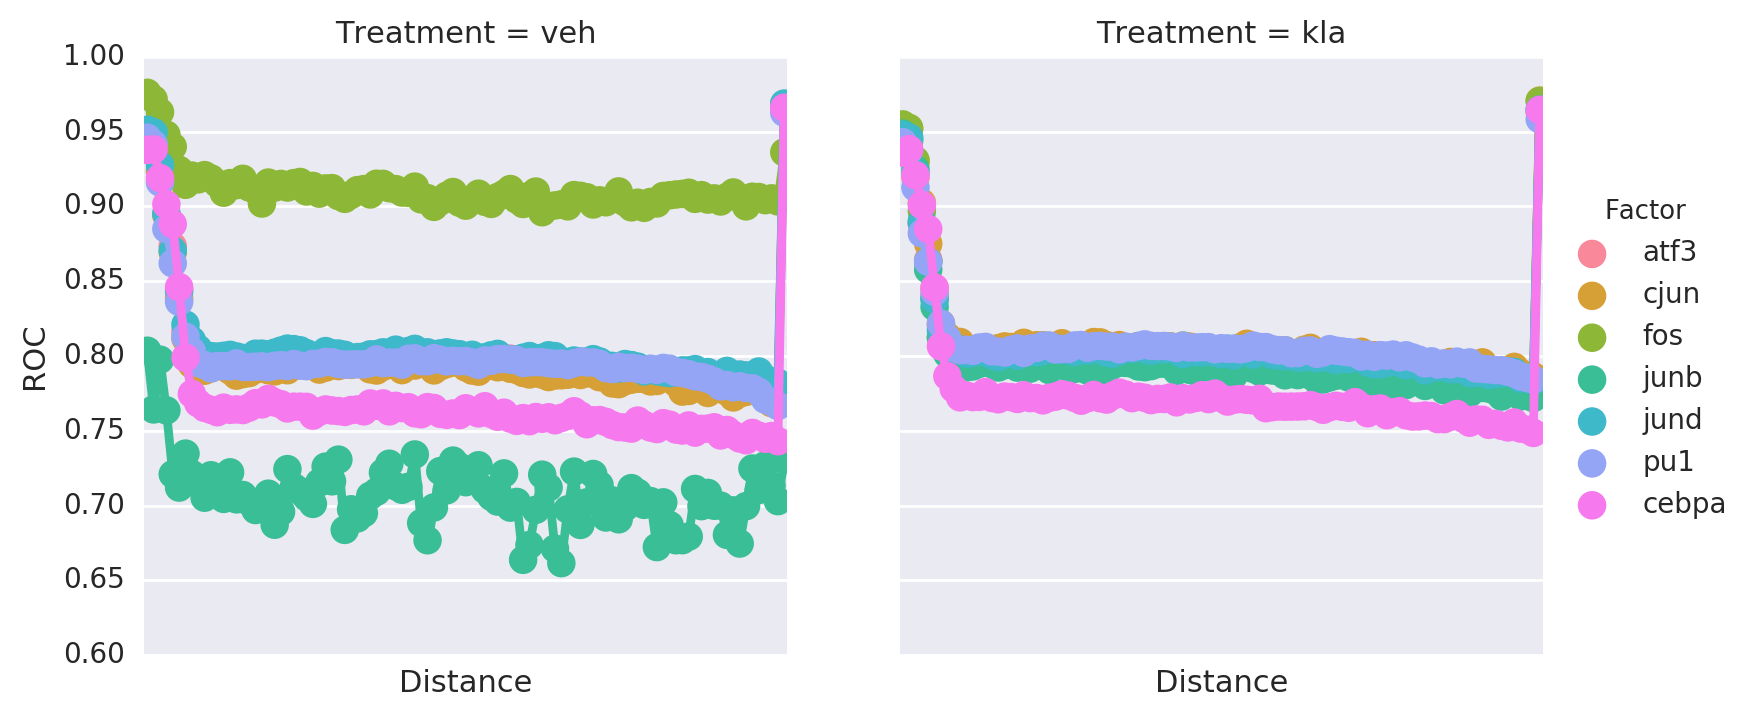

In [64]:
sns.factorplot(data=performance_frame,
              x = 'Distance',
              y='ROC',
              hue='Factor',
              col='Treatment')
plt.xticks([])


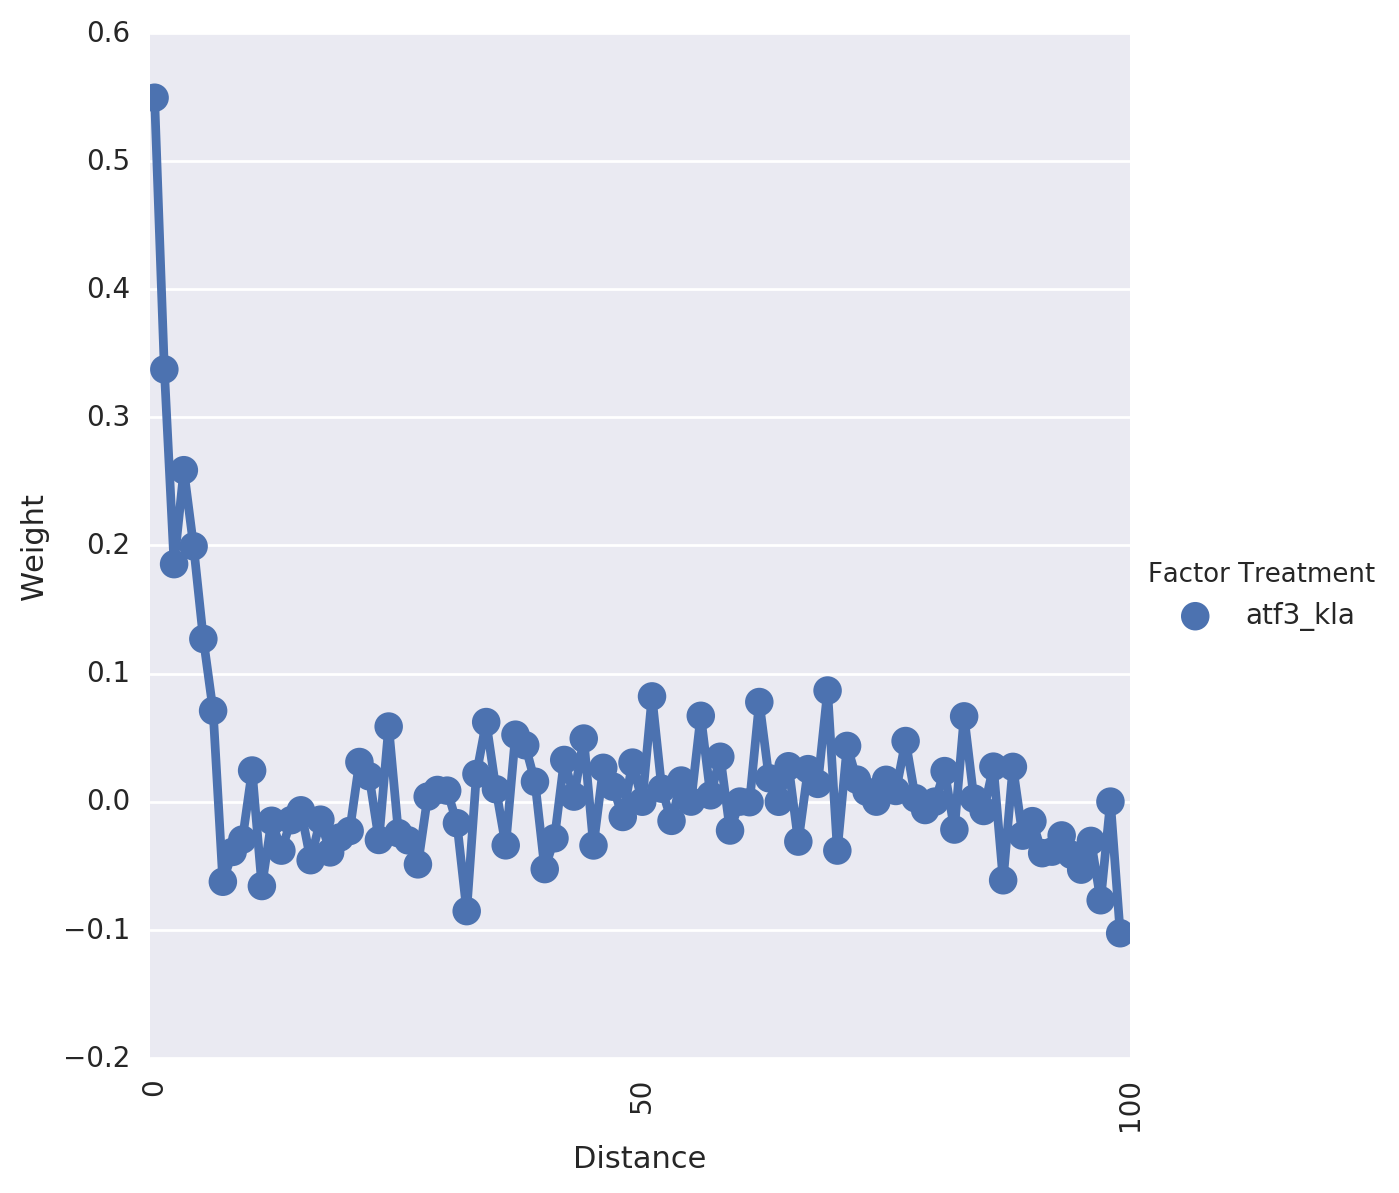

In [130]:
# average weights somehow...
factor_treatments = []
distances = []
weights = []
for factor_treatment in combined_weights_dict.keys():
    weights = weights + list(np.mean(combined_weights_dict[factor_treatment], axis=0))
    factor_treatments = factor_treatments + [factor_treatment] * 100
    distances = distances + list(range(100))
    

frame = pd.DataFrame({'Distance':distances, 'Weight':weights, 'Factor Treatment':factor_treatments})

sns.factorplot(data = frame[frame['Factor Treatment'] == 'atf3_kla'], 
               x='Distance', 
               y='Weight', 
               hue='Factor Treatment', 
               size=6,
              marker='.',
              s=0.1)
plt.xticks(rotation=90);
plt.xticks([0,50,100], [0,50,100]);

In [ ]:
interaction_distances = range(100)
for factor_treatment in combined_weights_dict.keys():
    mean_combined_weights = np.mean(combined_weights_dict[factor_treatment], axis=0)
    distance_weight_dict = dict(zip(interaction_distances, mean_combined_weights))
    individual_weights = []
    for dist in interaction_distances:
        mean_individual_weights = np.mean(interaction_weights_dict[factor_treatment][dist], axis=0)
        distance_weight = distance_weight_dict[dist]
        weighted_weights =  distance_weight * mean_individual_weights
        individual_weights.append(weighted_weights)
    individual_weights = np.array(individual_weights)
    
#     cg = sns.clustermap(individual_weights, 
#                     row_cluster=False,
#                     col_cluster=False,
#                     yticklabels=True, 
#                     xticklabels=False,
#                    vmax=0.04,
#                    vmin = -0.0
#                    )
#     plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6, rotation=0);



    weight_threshold = 0.8
    data = pd.DataFrame(individual_weights, columns=range(4096))
    mins = data.min(axis=1)
    differences = data[[]]
    for col in data.columns:
        differences[col] = data[col].values - mins.values
    mins.sort()
    sorted_differences = differences.ix[mins.index.values,:]
#     cg = sns.clustermap(sorted_differences,
#                         col_cluster=False,
#                        row_cluster=False,
#                        cmap='Blues')
#     plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
#     cg.ax_row_dendrogram.clear()
#     cg.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
#     cg.ax_row_dendrogram.set_yticks([])
# #     cg.ax_row_dendrogram.set_xlim(-6,6)
#     plt.suptitle(factor_treatment)
#     plt.show()


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [124]:
individual_weights.shape

(100, 4096)

In [127]:
mean_combined_weights.dot(individual_weights)

(1, 4096)